# Waveform Analysis Notebook
This script works for any simulation of the CoReDB:
- First plots the $rh_{22}$ waveform strain, amplitude and frequency.
- Compares faithfulness with $\mathcal{F}>\mathcal{F}_{thr}$ = $1-\frac{\epsilon^2}{2\rho^2}$. Here we use $\epsilon^2$ = 1,N=6 (for BNS) and $\rho$=SNR = 14, 30, 80 [Doulis:2022]
- Computes phase and amplitude differences (for $r\psi^4_{22}$), including the rescaled phase difference with scaling factor $SF=\frac{h^r_L - h^r_M}{h^r_M - h^r_H}$, with $r$ convergence rate, $h_{L_i}$ grid spacing at level $L_i$: L-Low, M-Medium, H-High.
- Finally, it checks for the phase differences at different consecutive extraction radii (for $r\psi^4_{22}$), as $\Delta^*\phi_{22}(R_i)=\phi_{22}(R_i)-\phi_{22}(R_{i-1})$ at one refinement level, see [Bernuzzi:2011].

Notes:
* The only input are basically the database key and the path of the `CoRe_DB_clone` on the second cell.
* By default it obtains the scaling factor for 2nd order convergence rate, but this can be changed below.
* Modify at own risk ..

[*Last Updated: 23.09.2022, AG*]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from watpy.utils.ioutils import *
from watpy.coredb.coredb import *
from watpy.utils.coreh5 import *
from watpy.wave.wave import wfile_parse_name
from watpy.wave.gwutils import windowing
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

matplotlib.rcParams['text.usetex']= True
matplotlib.rcParams['font.serif']= 'Times New Roman'
matplotlib.rcParams['font.size']= 15 #28

Msuns  = 4.925491025543575903411922162094833998e-6

## Color themes for the plots
c_runs = {
    'R01': '#66c2a5',
    'R02': '#fc8d62',
    'R03': '#8da0cb'
}

c_radii = {
    '700.0': '#8dd3c7',
    '750.0': 'gold',
    '800.0': '#bebada',
    '850.0': '#fb8072',
    '900.0': '#1f78b4',
    '1000.0': '#fdb462'
}

Now specify your `CoRe_DB_clone` path and the simulation to work with.

In [2]:
sim_path    = '../../watpy/msc/CoRe_DB_clone/'
dirc        = 'BAM:0066'
# Initialize DB
cdb = CoRe_db(sim_path)

Index found, updating...

git-pull core_database_index ...
 
done!
 Found R01
Found THC:0012
 Found R01
Found BAM:0075
 Found R01
Found THC:0027
 Found R01
Found BAM:0085
 Found R03
 Found R02
 Found R04
 Found R01
Found BAM:0099
 Found R02
 Found R01
Found BAM:0005
 Found R01
Found BAM:0069
 Found R01
Found BAM:0009
 Found R02
 Found R01
Found BAM:0125
 Found R02
 Found R01
Found BAM:0093
 Found R03
 Found R02
 Found R01
Found BAM:0070
 Found R03
 Found R02
 Found R04
 Found R01
Found BAM:0037
 Found R03
 Found R02
 Found R04
 Found R01
Found BAM:0062
 Found R03
 Found R06
 Found R02
 Found R05
 Found R04
 Found R01
Found THC:0019
 Found R02
 Found R01
Found BAM:0042
 Found R03
 Found R02
 Found R01
Found BAM:0107
skip Hyb_0014, not a DB key
 Found R01
Found THC:0002
 Found R02
 Found R01
Found BAM:0004
 Found R01
Found THC:0015
skip Hyb_0017, not a DB key
 Found R01
Found BAM:0074
 Found R01
Found BAM:0116
 Found R01
Found BAM:0080
 Found R01
Found THC:0033
 Found R01
Found THC:0025


In [3]:
idb = cdb.idb
sim = cdb.sim[dirc] # Calls simulation object
simmd = sim.md.data
eos = simmd['id_eos']
M = str("{:.1f}".format(float(simmd['id_mass'])))
q = str("{:.1f}".format(float(simmd['id_mass_ratio'])))
kappa2t = str("{:.1f}".format(float(simmd['id_kappa2T'])))
f0_Hz = float(simmd['id_gw_frequency_Hz'])

runs_in_sim = sim.run.keys()
if len(runs_in_sim)<3:
    print('A simulation with at least 3 different resolutions is necessary!')
else:
    print('This simulation has ',len(runs_in_sim),' runs in the DB.')

This simulation has  4  runs in the DB.


Let's now get the specifics of each run.

In [4]:
grlev   =   []
grlevmn =   []
gsmin   =   []
for run in runs_in_sim:
    simrun       =   sim.run[run]
    run_md       =   simrun.md.data
    gref_lev     =   float(run_md['grid_refinement_levels']) # Number of AMR refinement levels
    gref_lev_mn  =   float(run_md['grid_refinement_levels_moving_npoints']) # Grid point per direction i moving refinement levels
    gspa_min     =   float(run_md['grid_spacing_min']) # AMR minimum grid spacing
    grlev.append(gref_lev)
    grlevmn.append(gref_lev_mn)
    gsmin.append(gspa_min)

run_specs = list(zip(runs_in_sim,grlev,grlevmn,gsmin))
print(run_specs)

[('R03', 7.0, 120.0, 0.194), ('R02', 7.0, 160.0, 0.1455), ('R04', 7.0, 80.0, 0.291), ('R01', 7.0, 240.0, 0.097)]


### Plot strain
Selects run to plot and extracts the strain $rh_{22}$. In this case we choose the highest resolution run.

In [5]:
rmin, _ , _ , _ = run_specs[np.argmax(grlevmn)] # run with highest resolution
rmax, _ , _ , _ = run_specs[np.argmin(grlevmn)] # run with smallest resolution
run_min =   sim.run[rmin]
datah5 = run_min.data

dseth5 = datah5.read_dset()

rh22_files = list(dseth5['rh_22'].keys())[0] # different distances, take smallest distance
dset = dseth5['rh_22'][rh22_files] 

# read
t           = dset[:,0] # u/M
Reh        = dset[:,1] # Reh/M
Imh        = dset[:,2] # Imh/M
momg        = dset[:,5] # Momega
amp         = dset[:,6] # A/M #np.abs(Redh + 1j*Imdh) #dset[:,6]*M 
tmrg        = t[np.argmax(amp)]

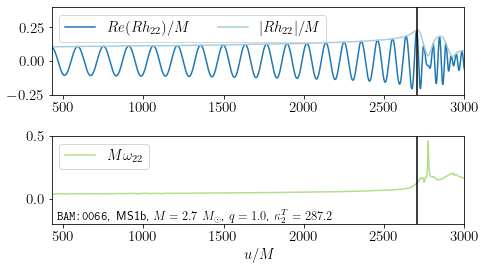

In [6]:
# WVF plot
end_wvf =   3000 ## CHANGE THIS IF NECESSARY
text = r'\texttt{'+dirc+'}, '+eos+', $M='+M+'~M_{\odot}$, $q='+q+'$, $\kappa^T_2='+kappa2t+'$'
fig, axs = plt.subplots(2,1,figsize=(7,4))
axs[0].plot(t,Reh,label=r'$Re(Rh_{22})/M$',color='#1f78b4')
axs[0].plot(t,amp,label=r'$|Rh_{22}|/M$', color='#a6cee3')
axs[0].axvline(x = tmrg, color = 'k') # Line to mark moment of merger
axs[0].set_xlim([430,end_wvf])
axs[0].set_ylim([-0.25,0.4])
axs[0].legend(ncol=3,loc='upper left')


axs[1].plot(t,momg,label=r'$M\omega_{22}$',color='#b2df8a')
axs[1].text(463,-0.17,text,fontsize='small')
axs[1].axvline(x = tmrg, color = 'k')
axs[1].set_xlim([430,end_wvf])
axs[1].set_ylim([-0.2,0.5])
axs[1].legend(ncol=3,loc='upper left')

plt.xlabel(r'$u/M$')
plt.tight_layout()
#plt.savefig('strain_waveform.pdf')
plt.show()

### Phase & Amplitude differences
Done at each resolution: HIG-FIN, MID-HIG, LOW-MID, for  $r\psi^4_{22}$ at the lowest extraction radius.

In [7]:
three_sims = True
if len(run_specs)==3:
    tags = ['HIG','MID','LOW']
elif len(run_specs)==4:
    tags = ['FIN','HIG','MID','LOW']
    three_sims = False
flag = []
npoints_old = 200
amplitudes = []
phases = []
times = []
tmerg = []
for i,run in enumerate(runs_in_sim):
    # tagging each run
    if run==rmin:
        flag.append(tags[0])
    elif run==rmax:
        flag.append(tags[-1])
    else:
        _, _ , npoints , _ = run_specs[i]
        if npoints<npoints_old:
            flag.append(tags[2])
            npoints_old = npoints
        else:
            flag.append(tags[1])
    # Extract amplitudes & phases
    simr = sim.run[run]
    dh5 = simr.data
    dsh5 = dh5.read_dset()
    rp4_files = list(dsh5['rpsi4_22'].keys())[0] # different distances and take smallest distance
    dset = dsh5['rpsi4_22'][rp4_files]
    uM          = dset[:,0]
    amp         = dset[:,4] 
    phi         = dset[:,5]
    tmrg        = uM[np.argmax(amp)]
    amplitudes.append(amp)
    phases.append(phi)
    times.append(uM)
    tmerg.append(tmrg)

# Interpolate arrays
index_finhig = [i for i in range(len(flag)) if flag[i]==tags[0]][0] # index with the highest resolution
index_2 = [i for i in range(len(flag)) if flag[i]==tags[1]][0] # for the second ..
index_3 = [i for i in range(len(flag)) if flag[i]==tags[2]][0] # for the third ..
if three_sims==False:
    index_4 = [i for i in range(len(flag)) if flag[i]==tags[3]][0]
    
for i in range(len(flag)):
    if i==index_finhig:
        continue
    else:
        phases[i] = np.interp(times[index_finhig], times[i], phases[i])
        amplitudes[i] = np.interp(times[index_finhig], times[i], amplitudes[i])


We compute now the scaling factor for the amplitude and phase differences, choose the convergence rate accordingly in `conv_rate`.

In [8]:
# scaling factor
def scaling_factor(r):
    hL = gsmin[index_3] #0.194
    hM = gsmin[index_2] #0.145
    hH = gsmin[index_finhig] #0.097
    return (hL**r - hM**r)/(hM**r - hH**r)

print('SF(2) = ',scaling_factor(2),', SF(4) = ',scaling_factor(4))
conv_rate = 2 # choose convergence rate to use
SF= scaling_factor(conv_rate) 

SF(2) =  1.4000000000000008 , SF(4) =  2.6923076923076943


In [9]:
# Get differences
phi_diff_21 = phases[index_2]-phases[index_finhig]
pd21_rescaled = SF*phi_diff_21
phi_diff_32 = phases[index_3]-phases[index_2]
pd32_rescaled = SF*phi_diff_32

amp_diff_21 = amplitudes[index_2]-amplitudes[index_finhig]
ad21_rescaled = SF*amp_diff_21
amp_diff_32 = amplitudes[index_3]-amplitudes[index_2]
ad32_rescaled = SF*amp_diff_32

if three_sims==False:
    phi_diff_43 = phases[index_4]-phases[index_3]
    pd43_rescaled = SF*phi_diff_43

    amp_diff_43 = amplitudes[index_4]-amplitudes[index_3]
    ad43_rescaled = SF*amp_diff_43


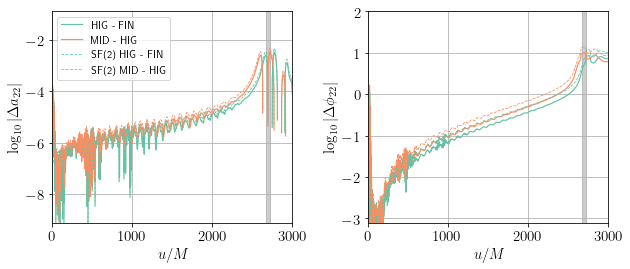

In [10]:
## Plotting

fig, axs = plt.subplots(1,2,figsize=(9,4))
label_21 = flag[index_2]+' - '+flag[index_finhig]
label_32 = flag[index_3]+' - '+flag[index_2] 
#if three_sims==False:
#    label_43 = flag[index_4]+' - '+flag[index_3]
axs[0].plot(times[index_finhig],np.log10(amp_diff_21),'-',label=label_21,color=c_runs['R01'],linewidth=1.2)
axs[0].plot(times[index_finhig],np.log10(amp_diff_32),'-',label=label_32,color=c_runs['R02'],linewidth=1.2)
#if three_sims==False:
#    axs[0].plot(times[index_finhig],np.log10(amp_diff_43),'-',label=label_43,color=c_runs['R03'],linewidth=1.2)
axs[0].plot(times[index_finhig],np.log10(ad21_rescaled),'--',label=r'SF('+str(conv_rate)+') '+label_21,color=c_runs['R01'],linewidth=0.8)
axs[0].plot(times[index_finhig],np.log10(ad32_rescaled),'--',label=r'SF('+str(conv_rate)+') '+label_32,color=c_runs['R02'],linewidth=0.8)
axs[0].fill_betweenx(y=np.arange(-20.,20.,0.1),x1=tmerg[index_finhig],x2=tmerg[index_2],color='gray',alpha=0.4)
#axs[0].fill_betweenx(y=np.arange(-20.,20,0.1),x1=tmrg3,x2=tmrg2,color='gray',alpha=0.2)
axs[0].set_xlim([0,end_wvf])
axs[0].set_ylim([-9.1,-0.9])
axs[0].set_ylabel(r'$\log_{10}|\Delta a_{22}|$')
axs[0].set_xlabel(r'$u/M$')
axs[0].grid(True)
axs[0].legend(loc='upper left',fontsize='x-small')

axs[1].plot(times[index_finhig],np.log10(np.abs(phi_diff_21)),'-',label=label_21,color=c_runs['R01'],linewidth=1.2)
axs[1].plot(times[index_finhig],np.log10(np.abs(phi_diff_32)),'-',label=label_32,color=c_runs['R02'],linewidth=1.2)
#if three_sims==False:
#    axs[1].plot(times[index_finhig],np.log10(np.abs(phi_diff_43)),'-',label=label_43,color=c_runs['R03'],linewidth=1.2)
axs[1].plot(times[index_finhig],np.log10(pd21_rescaled),'--',label=r'SF('+str(conv_rate)+') '+label_21,color=c_runs['R01'],linewidth=0.8)
axs[1].plot(times[index_finhig],np.log10(pd32_rescaled),'--',label=r'SF('+str(conv_rate)+') '+label_32,color=c_runs['R02'],linewidth=0.8)
axs[1].fill_betweenx(y=np.arange(-20.,20.,0.1),x1=tmerg[index_finhig],x2=tmerg[index_2],color='gray',alpha=0.4)
#axs[1].fill_betweenx(y=np.arange(-20.,20.,0.1),x1=tmrg3,x2=tmrg2,color='gray',alpha=0.2)
axs[1].set_xlim([0,end_wvf])
axs[1].set_ylim([-3.1,2])
axs[1].set_ylabel(r'$\log_{10}|\Delta\phi_{22}|$')
axs[1].set_xlabel(r'$u/M$')
axs[1].grid(True)


plt.tight_layout()
#plt.savefig('amp_phase_conv.pdf')
plt.show()

### Finite-radius extraction uncertainties
For $r\psi^4_{22}$ between consecutive radii, according to $\Delta^*\phi_{22}(R_i)=\phi_{22}(R_i)-\phi_{22}(R_{i-1})$ (similarly for the amplitude $\Delta^*a_{22}/a_{22}$)

In [11]:
file_list = list(dseth5['rpsi4_22'].keys()) # files for each radius for highest resolution run


750.0  -  700.0
800.0  -  750.0
850.0  -  800.0
900.0  -  850.0


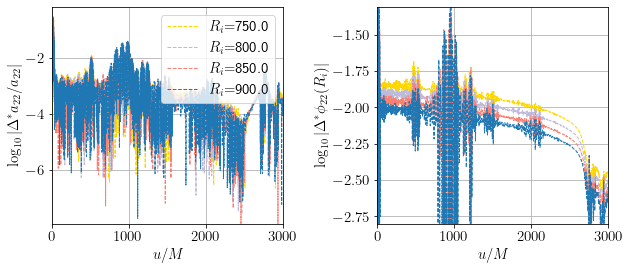

In [14]:
fig, axs = plt.subplots(1,2,figsize=(9,4))

for i in range(1,len(file_list)-1):
    file1 = file_list[i]
    file2 = file_list[i-1]
    _,_,_,rad1,_ = wfile_parse_name(file1) 
    _,_,_,rad2,_ = wfile_parse_name(file2)
    print(rad1, " - ",rad2)
    rad_s = str(rad1)
    dset = dseth5['rpsi4_22'][file1] 
    # read 1
    t           = dset[:,0] #u/M
    Redh        = dset[:,1]
    Imdh        = dset[:,2]
    phi         = dset[:,5] #np.unwrap(np.angle(Redh + 1j*Imdh))#dset[:,7][Njunk:]
    amp         = dset[:,4] 
    tmrg        = t[np.argmax(amp)]
    # read 2
    dset2 = dseth5['rpsi4_22'][file2] ## same resolution!!
    t2           = dset2[:,0] #u/M
    Redh2        = dset2[:,1]
    Imdh2        = dset2[:,2]
    phi2         = dset2[:,5] #np.unwrap(np.angle(Redh2 + 1j*Imdh2)) #dset2[:,7][Njunk:]
    amp2         = dset2[:,4]
    tmrg2        = t2[np.argmax(amp2)]
    
    # adjusting dephasings --> ADJUST ACCORDINGLY !! (maybe it's not even necessary)
    if rad1==750.0:
        phi= phi - 2*np.pi
        phi2 = phi2 - 2*2*np.pi
    elif rad1==850.0:
        phi= phi - 2*2*np.pi
        phi2 = phi2 - 4*2*np.pi
    elif rad1==1000.0:
        phi = phi - 3*2*np.pi
    elif rad1==800.0:
        phi = phi - 4*2*np.pi
        phi2 = phi2 - 2*np.pi
    elif rad1==900.0:
        phi2=phi2-2*2*np.pi
    
    # Amplitude
    amp2 = np.interp(t, t2, amp2)
    amp_diff = (amp-amp2)/amp
    #amp_diff = signal.savgol_filter(amp_diff, window_length=31, polyorder=3)
    axs[0].plot(t,np.log10(np.abs(amp_diff)),'--',linewidth=1,label=r'$R_i$='+rad_s,color=c_radii[rad_s])
    #axs[0].fill_betweenx(y=np.arange(-20.,15.2,0.1),x1=tmrg2,x2=tmrg,color='gray',alpha=0.2)
    # Phase
    phi2 = np.interp(t, t2, phi2)
    phi_diff = np.abs(phi)-np.abs(phi2)
    #phi_diff = signal.savgol_filter(phi_diff, window_length=31, polyorder=3)
    axs[1].plot(t,np.log10(np.abs(phi_diff)),'--',label=r'$R_i$='+rad_s,linewidth=1,color=c_radii[rad_s])
    #axs[1].fill_betweenx(y=np.arange(-150.,150.2,1),x1=tmrg2,x2=tmrg,color='gray',alpha=0.2)

axs[0].set_ylabel(r'$\log_{10}|\Delta^*a_{22}/a_{22}|$')
axs[0].set_xlabel(r'$u/M$')
axs[0].set_xlim([0,end_wvf])
axs[0].set_ylim([-7.9,-0.2])
#axs[0].set_ylim([-0.022,0.045]) for non log
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].set_xlim([0,end_wvf])
axs[1].set_ylim([-2.8,-1.31])
#axs[1].set_ylim([-0.004,0.026]) for non log
axs[1].set_ylabel(r'$\log_{10}|\Delta^*\phi_{22}(R_i)|$')
axs[1].set_xlabel(r'$u/M$')
axs[1].grid(True)
#plt.legend()
plt.tight_layout()
#plt.savefig('bam66_amp_phase_star.pdf')
plt.show()

### Faithfulness
Obtained between the highest and second highest resolutions of $rh_{22}$ with PSD aLIGOZeroDetHighPower. For this part one needs *PyCBC*, it can be installed via `pip install pycbc`.

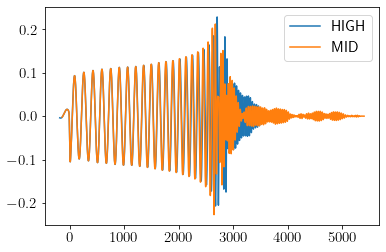

In [ ]:
#from watpy.wave.gwutils import *
Njunk = 600

## first highest
simrun1 = sim.run[list(runs_in_sim)[index_finhig]]
datah51 = simrun1.data
dseth51 = datah51.read_dset()
rh22_files1 = list(dseth51['rh_22'].keys())[0]
ds1 = dseth51['rh_22'][rh22_files1]
h1           = ds1[:,1][Njunk:]
hc1           = ds1[:,2][Njunk:]
t1           = ds1[:,0][Njunk:]
ht1          = h1 + 1j*hc1
amp1        = np.abs(ht1)#ds1[:,6][Njunk:]
pp1 = -np.unwrap(np.angle(ht1))
freq1       = np.abs(np.diff(pp1)/np.diff(t1))#ds1[:,5][Njunk:]
fmerg       = freq1[np.argmax(amp1)] # frequency at merger

## second highest
simrun2 = sim.run[list(runs_in_sim)[index_2]]
datah52 = simrun2.data
dseth52 = datah52.read_dset()
rh22_files2 = list(dseth52['rh_22'].keys())[0]
ds2 = dseth52['rh_22'][rh22_files2]
h2           = ds2[:,1][Njunk:]
hc2           = ds2[:,2][Njunk:]
t2           = ds2[:,0][Njunk:]

plt.plot(t1,h1,label='HIGH')
plt.plot(t2,h2,label='MID')
plt.legend()
plt.show()

In [ ]:
from pycbc.psd import aLIGODesignSensitivityP1200087, AdVDesignSensitivityP1200087, EinsteinTelescopeP1600143, aLIGOZeroDetHighPower #choose your PSD

# Frequency ranges
fmin = f0_Hz
fmax = fmerg/(2*np.pi*float(M)*Msuns)

# dT= 1./4096.
# t1i = np.arange(t1[0], t1[-1], dT)
# h1 = np.interp(t1i, t1, h1)
# t2i = np.arange(t2[0], t2[-1], dT)
# h2 = np.interp(t2i, t2, h2)

# # Tapering
# alpha = 0.001
# L = t1i[-1] # length of signal in seconds
# h1t, _ = windowing(h1, alpha/L)
# L = t2i[-1]
# h2t, _ = windowing(h2, alpha/L)

# Generate the aLIGO ZDHP PSD
tlen = max(len(h1), len(h2))
delta_f = 1.0 / t1[-1]
flen    = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, fmin)
fpsd = psd.sample_frequencies

# # Matching with watpy function
# m = match(t1i, h1t, t2i, h2t, fpsd, psd, fmin, fmax) # watpy's function
# mm = 1.0-m # mismatch
# print("Unfaithfulness: ", mm, ', fmin = ',fmin,' fmax = ',fmax)


In [ ]:
from pycbc.filter import optimized_match
from pycbc.types.timeseries import TimeSeries

dT = 1./4096.                  
hp_nrTS   = TimeSeries(h1, dT)
hp_nrTS_l   = TimeSeries(h2, dT)
                  
# Tapering
alpha = 0.001
L = hp_nrTS.duration # length of signal in seconds
hp_nrTS, _ = windowing(hp_nrTS, alpha/L)
L = hp_nrTS_l.duration
hp_nrTS_l, _ = windowing(hp_nrTS_l, alpha/L)

# Resize
tlen = max(len(hp_nrTS), len(hp_nrTS_l))
hp_nrTS.resize(tlen)
hp_nrTS_l.resize(tlen)
       
# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hp_nrTS.duration
flen    = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, fmin)

m1,  _   = optimized_match(hp_nrTS, hp_nrTS_l, psd=psd, low_frequency_cutoff=fmin, high_frequency_cutoff=fmax) # pycbc function
print("unfaithfulness (MID-HIG): ",1.-m1)                   

unfaithfulness (MID-HIG):  9.911316426614025e-05


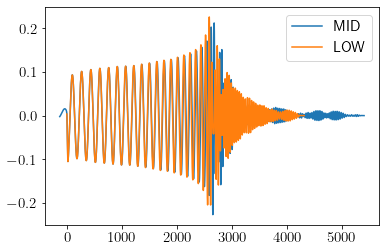

In [ ]:
## third highest
simrun3 = sim.run[list(runs_in_sim)[index_3]]
datah53 = simrun3.data
dseth53 = datah53.read_dset()
rh22_files3 = list(dseth53['rh_22'].keys())[0]
ds3 = dseth53['rh_22'][rh22_files3]
h3           = ds3[:,1][Njunk:]
t3           = ds3[:,0][Njunk:]

plt.plot(t2,h2,label='MID')
plt.plot(t3,h3,label='LOW')
plt.legend()
plt.show()

In [ ]:

ht2          = h2 + 1j*hc2
amp2        = np.abs(ht2)#ds2[:,6][Njunk:]
pp2 = -np.unwrap(np.angle(ht2))
freq2       = np.abs(np.diff(pp2)/np.diff(t2))#ds2[:,5][Njunk:]
fmerg2       = freq2[np.argmax(amp2)] # frequency at merger

fmax = fmerg2/(2*np.pi*float(M)*Msuns)

hp_nrTS   = TimeSeries(h2, dT)
hp_nrTS_l   = TimeSeries(h3, dT)
                  
# Tapering
alpha = 0.001
L = hp_nrTS.duration # length of signal in seconds
hp_nrTS, _ = windowing(hp_nrTS, alpha/L)
L = hp_nrTS_l.duration
hp_nrTS_l, _ = windowing(hp_nrTS_l, alpha/L)

# Resize
tlen = max(len(hp_nrTS), len(hp_nrTS_l))
hp_nrTS.resize(tlen)
hp_nrTS_l.resize(tlen)
       
# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hp_nrTS.duration
flen    = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, fmin)

m2,  _   = optimized_match(hp_nrTS, hp_nrTS_l, psd=psd, low_frequency_cutoff=fmin, high_frequency_cutoff=fmax) # pycbc function
print("unfaithfulness (MID-HIG): ",1.-m2)                   

unfaithfulness (MID-HIG):  0.0019160967331193213


In [ ]:
uf = [1.-m2, 1.-m1] #unfaithfulness
luf = np.log10(uf)
_, _, rn1, _ = run_specs[index_finhig]
_, _, rn2, _ = run_specs[index_2]
resos = [rn2, rn1] # npoints

### Faithfulness threshold
$\mathcal{F}>\mathcal{F}_{thr}$ = $1-\frac{\epsilon^2}{2\rho^2}$

In this case we use $\epsilon^2$ = 1,6 and $\rho$=SNR  14, 30, 80.

In [ ]:
# Faithfulness Threshold computation

snr = [14, 30, 80]
ep2 = [1, 6]
ft_1 = [] # for \episilon^2 = 1
ft_6 = [] # for \episilon^2 = 6
for ss in snr:
    fthr1 = 1. - ep2[0] / (2*ss**2)
    fthr6 = 1. - ep2[1] / (2*ss**2)
    ft_1.append(fthr1)
    ft_6.append(fthr6)

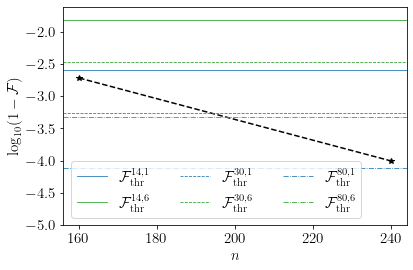

In [ ]:
# Plotting

lstyle = ['-','--','-.']

plt.plot(resos,luf,'*--',color='k',label='')
plt.ylabel(r'$\log_{10}(1-\mathcal{F})$')
plt.xlabel(r'$n$')
fs = 'small'
for i, lf in enumerate(ft_1):
    if i==0:
        label1 = r'$\mathcal{F}^{14,1}_{\rm thr}$'
        label2 = r'$\mathcal{F}^{14,6}_{\rm thr}$'
        #plt.text(230,-2.74,label1,fontsize=fs, color='tab:blue')
        #plt.text(170,-1.76,label2,fontsize=fs, color='tab:green')
    elif i==1:
        label1 = r'$\mathcal{F}^{30,1}_{\rm thr}$'
        label2 = r'$\mathcal{F}^{30,6}_{\rm thr}$'
        #plt.text(230,-3.2,label1,fontsize=fs, color='tab:blue')
        #plt.text(170,-2.43,label2,fontsize=fs, color='tab:green')
    else:
        label1 = r'$\mathcal{F}^{80,1}_{\rm thr}$'
        label2 = r'$\mathcal{F}^{80,6}_{\rm thr}$'
        #plt.text(230,-4.06,label1,fontsize=fs, color='tab:blue')
        #plt.text(170,-3.47,label2,fontsize=fs, color='tab:green')
    
    plt.axhline(y=np.log10(1-lf),linestyle=lstyle[i],color='tab:blue',linewidth=0.8,label=label1)
    plt.axhline(y=np.log10(1-ft_6[i]),linestyle=lstyle[i],color='tab:green',linewidth=0.8,label=label2)
plt.ylim([-5,-1.62])
plt.legend(ncol=3,loc='lower left')
plt.tight_layout()
#plt.savefig('bam66_matching.pdf')
plt.show()